# **South African Language Detection Competition**

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from wordcloud import WordCloud
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth',200)
# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

## **Introduction**

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

>##### *Problem Statement*
>Given the text in any of South Africa's 11 Official languages  in the dataset provided, identify which language the text is in.

## **Loading data**

The data for this competiton comes with two sets files, **train.csv** and **test.csv**. 

In [2]:
train = pd.read_csv('../input/south-african-language-identification/train_set.csv')
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...
2,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...


In [3]:
test = pd.read_csv('../input/south-african-language-identification/test_set.csv')
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlelela kgato eo."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye imitlolo engezelelako ukuqedelela ukutloliswa kwesibawo sakho.
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini naticocisana.
4,5,Winste op buitelandse valuta.


>The train dataset has a total of three columns, while the test dataset consists of two columns. 

A description of the rows or columns of each data is given below:
 ##### Variable Description:
 * lang_id : language ID
 * text: sentences in a south african language
##### Class Description:
 * afr - Afrikaans
 * eng - English
 * nbl - isiNdebele
 * nso - Sepedi
 * sot - Sesotho
 * ssw - siSwati
 * tsn - Setswana
 * tso - Xitsonga
 * ven - Tshivenda
 * xho - isiXhosa
 * zul - isiZulu

### **Text Preprocessing**

Text is an unstructured form of data,much more so text that is a language. Although some text processing has been applied to the text data, further cleaning could still be done.

In [4]:
# creating a list for appending the preprocessed text
def clean_text(data):
    i = 0
    # iterating through all the text
    for text in data['text']:
       # removing the symbols and numbers
        text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text)
        text = re.sub(r'[[]]', ' ', text)
        # converting the text to lower case
        text = text.lower()
        # equating the text in position i to cleaned text
        data.loc[i, 'text'] = text
        i += 1

In [5]:
#calling the funtion
clean_text(train)
train.head()# shows the first five rows

,lang_id,text
0,xho,umgaqo-siseko we za amalu giselelo kumaziko axhasa ulawulo lwesi i zi ku ye okuthath i xaxheba kwabafazi ezi ziquka phakathi kwezi ye zazo ikomisho i yokuli ga a gokwesi i ikomisho i yamalu gelo...
1,xho,i-dha iya kuba obulumko bokubeka umsebe zi aphi a kwisebe gokusekwe kwiimfu o zokusebe za zalo emva kokubo a a omsebe zi ku ye oka ye ima ya o yakhe ukuba ula dulo lom tu o jalo alufa eleka g...
2,eng,the provi ce of kwazulu- atal departme t of tra sport i vites te ders from established co tractors experie ced i bridge co structio for the co structio of the kwajolwayo tugela river pedestria ...
3,nso,o etefatša gore o ba file dilo ka moka tše le dumelela ego ka tšo a mohlala maleri a magolo a a šomišwago go fihlelela meago g e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...
4,ven,khomishi i ya di ga yiso ya mbeu yo ewa maa a u ya ga mulayo wa khomishi i ya di ga yiso ya mbeu u thetshelesa mbilaelo dzi e dza tshimbilela a a tshialula u ya ga mbeu aho e i ivhea sa fora...


A simple function was defined to remove symbols and numbers from the text and converting all text to lowercase. Although some symbols way be part of the language such **Noises** would not allow algorithms train the data.

### **Exploratory Data Analysis(EDA)**

In this portion, the aim is to analyse data, investigating the dataset to discover patterns and make some hypotheses on the data.

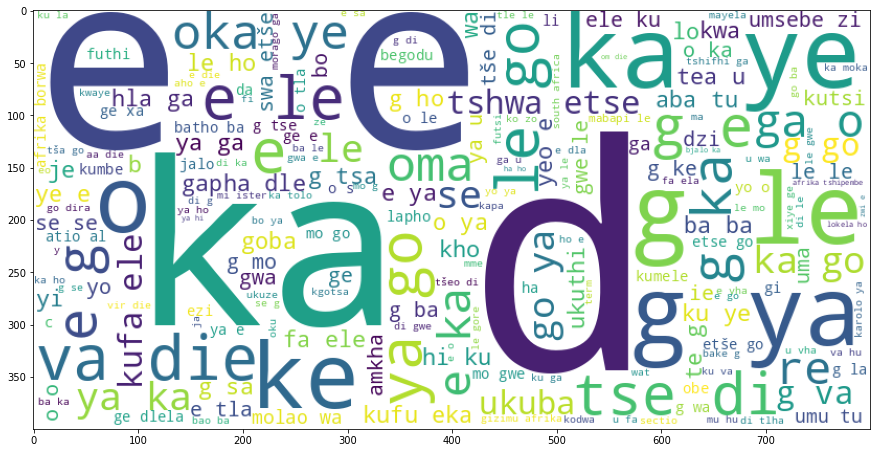

In [6]:
#wordcloud to show words in the text 
allwords = ' '.join( [tweets for tweets in train['text']])
wordCloud = WordCloud(background_color='white',width=800, height=400,random_state=42).generate(allwords)
plt.figure( figsize=(15,10) )
plt.imshow(wordCloud)

In [7]:
train.shape#shows value of rows and columns

(33000, 2)

In [8]:
train.info()#diplays information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [9]:
train.isna().sum()

lang_id    0
text       0
dtype: int64

Looking at the train data, it has a shape with 33000 rows and 2 columns. These rows and column of data are of the **object type**, and each column have no null rows.

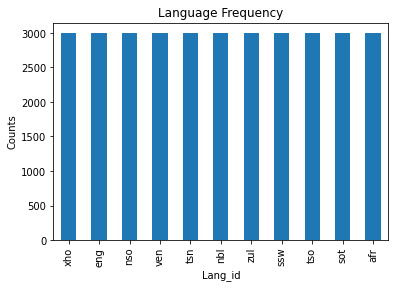

In [10]:
# counts the number of each unique language ID
train['lang_id'].value_counts().plot(kind='bar')
#plot and visualize the counts
plt.title('Language Frequency')
plt.xlabel('Lang_id')
plt.ylabel('Counts')
plt.show()

Noticeably, the data is balanced with each language on the X-axis having 3000 counts.

In [11]:
# features
X = train["text"]
# Label
y = train["lang_id"]

Assigning the feature column as X and the label as Y to train the data

In [12]:
le = LabelEncoder()#instance of labelencoder
y = le.fit_transform(y)#transforming label data

The label data was encoded to a format that makes it easy to analyse by the coming algorithms

In [13]:
cv = CountVectorizer(analyzer = 'char', ngram_range=(1,2))#instance of countvecorizer
X = cv.fit_transform(X)#transform the feature data
X.shape

(33000, 1163)

CountVectorizer transforms a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. The code above analyses the text per character with the unigram and bigram range.

In [14]:
# splitting data t
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [15]:
x_train.shape

(26400, 1163)

The data was split giving a test-size of 20%, while 80% is assigned to training the data to made predictions using various models

### **Modelling**

We woulb be looking at three different models and testing their accuracies to determine which works wells with the data set.
* RandomForest Classifier
* Logistic Regression
* MultinomialNB

##### **RandomForest Classifier**

In [16]:
clf=RandomForestClassifier()#instance of randomforest

In [17]:
clf.fit(x_train,y_train)#fitting x and y train to random forest algorithm

RandomForestClassifier()

In [18]:
RD_y_pred=clf.predict(x_test)# prediction for randomforest
print(confusion_matrix(y_test,RD_y_pred))#displays confusion matrix
RD_accuracy = accuracy_score(y_test, RD_y_pred)#calculates accuracy score
print(f'Accuracy : {RD_accuracy}')#prints accuracy score
print(f'{classification_report(y_test, RD_y_pred)}')#prints classfication report

[[583   0   0   0   0   0   0   0   0   0   0]
 [  0 615   0   0   0   0   0   0   0   0   0]
 [  0   0 565   0   0   0   0   0   0   4  14]
 [  0   0   0 620   1   0   4   0   0   0   0]
 [  0   0   0   0 618   0   0   0   0   0   0]
 [  0   0   0   0   0 582   0   0   0   1   1]
 [  0   2   0   2   1   0 593   0   0   0   0]
 [  0   0   0   0   0   0   0 561   0   0   0]
 [  0   0   0   0   0   0   0   0 634   0   0]
 [  0   0   1   0   0   0   0   0   0 585  23]
 [  0   0   4   0   0   0   0   0   0  16 570]]
Accuracy : 0.9887878787878788
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       615
           2       0.99      0.97      0.98       583
           3       1.00      0.99      0.99       625
           4       1.00      1.00      1.00       618
           5       1.00      1.00      1.00       584
           6       0.99      0.99      0.99       598
           7       

##### **Logistic Regression**

In [19]:
lm = LogisticRegression(multi_class='ovr')#instance of logistic regression

In [20]:
lm.fit(x_train,y_train)#fitting x and y train to logistic regression algorithm

LogisticRegression(multi_class='ovr')

In [21]:
pred_lm = lm.predict(x_test)#prediction on test 
print(confusion_matrix(y_test,pred_lm))#displays confusion matrix
LM_accuracy= accuracy_score(y_test, pred_lm)#calculates accuracy score
print(f'Accuracy : {LM_accuracy}')#prints accuracy score
print(f'{classification_report(y_test, pred_lm)}')#prints classfication report

[[583   0   0   0   0   0   0   0   0   0   0]
 [  0 615   0   0   0   0   0   0   0   0   0]
 [  0   0 570   0   0   0   0   0   0   4   9]
 [  0   0   0 621   1   0   3   0   0   0   0]
 [  0   0   0   0 617   0   0   0   0   0   1]
 [  0   0   0   0   0 583   0   0   0   0   1]
 [  0   1   0   1   0   0 596   0   0   0   0]
 [  0   0   0   0   0   0   0 561   0   0   0]
 [  0   0   0   0   0   0   0   0 634   0   0]
 [  0   0   6   0   0   0   0   0   0 595   8]
 [  0   0   6   0   0   0   0   0   0  20 564]]
Accuracy : 0.9907575757575757
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       615
           2       0.98      0.98      0.98       583
           3       1.00      0.99      1.00       625
           4       1.00      1.00      1.00       618
           5       1.00      1.00      1.00       584
           6       0.99      1.00      1.00       598
           7       

In [22]:
model = MultinomialNB()#instance of MNB
model.fit(x_train, y_train)#fitting train to algorithm

MultinomialNB()

In [23]:
MNB_y_pred = model.predict(x_test)#prediction on test 
print(confusion_matrix(y_test,MNB_y_pred))#displays confusion matrix
MNB_accuracy = accuracy_score(y_test, MNB_y_pred)#calculates accuracy score
print(f'Accuracy : {MNB_accuracy}')#prints accuracy score
print(f'{classification_report(y_test, MNB_y_pred)}')#prints classfication report

[[583   0   0   0   0   0   0   0   0   0   0]
 [  0 615   0   0   0   0   0   0   0   0   0]
 [  0   0 565   0   0   0   0   0   0   6  12]
 [  0   0   0 622   0   0   3   0   0   0   0]
 [  0   0   0   0 616   0   2   0   0   0   0]
 [  0   0   0   0   0 582   0   0   0   0   2]
 [  0   2   0   0   0   0 596   0   0   0   0]
 [  0   0   0   0   0   0   0 561   0   0   0]
 [  0   0   0   0   0   0   0   0 634   0   0]
 [  0   0   6   0   0   1   0   0   0 568  34]
 [  0   0  18   0   0   0   0   0   0  21 551]]
Accuracy : 0.9837878787878788
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       615
           2       0.96      0.97      0.96       583
           3       1.00      1.00      1.00       625
           4       1.00      1.00      1.00       618
           5       1.00      1.00      1.00       584
           6       0.99      1.00      0.99       598
           7       

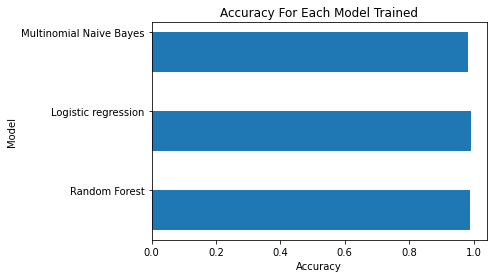

In [24]:
#bar plot to show model accuracy
models = ['Random Forest', 'Logistic regression','Multinomial Naive Bayes']
bar_widths = [RD_accuracy, LM_accuracy, MNB_accuracy]
bar_positions = arange(3) + 0.75
tick_positions = range(1,4)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(models)

ax.set_ylabel('Model')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy For Each Model Trained')

plt.show()

There is no obvious difference between all three models when comparing with bar plot. RandomForest classifier and Logistic regession had an accuracy score of 99%,leaving Multinominal Naive Bayes with a 98% accuracy.

### **Test and Submission**

In [25]:
clean_text(test)#cleaning the test data
test.head()#displays first five rows

,index,text
0,1,mmasepala fa maemo a a kgethegile g a letlelela kgato eo.
1,2,uzakwaziswa gokufa eleko aku gafu eka emi ye imitlolo e gezelelako ukuqedelela ukutloliswa kwesibawo sakho.
2,3,tshivhumbeo tshi fa a a ga o dza vhathu.
3,4,kube i ja elikati beti gevakala kutsi titsi i aticocisa a.
4,5,wi ste op buitela dse valuta.


In [26]:
df_test = test['text']# selects the text column

In [27]:
#transforms the text column to vector
df_test = cv.transform(df_test).toarray()

In [28]:
predictions = lm.predict(df_test)#making orediction of test data
predictions = le.inverse_transform(predictions)# transforms prediction back to text

In [29]:
submission = pd.DataFrame({'index': test['index'], 'lang_id': predictions})
submission.head()

,index,lang_id
0,1,nso
1,2,nbl
2,3,ven
3,4,ssw
4,5,ssw


In [30]:
submission.to_csv('LogisticRegression_model.csv', index=False , header = 1)